# 2 - Variogram Models

This tutorial will guide you through the theoretical variogram models available for the `Variogram` class. 

**In this tutorial you will learn:**

* how to choose an appropiate model function
* how to judge fitting quality
* about sample size influence

In [1]:
import skgstat as skg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 2.1 Load data

For this example we will use the pancake dataset. You can use the ``skgstat.data`` submodule to directly sample the dataset. This is the red-channel of an image of an actual pancake. The intersting thing about this pancake is, that it shows some clear spatial structures in its browning, but of different shapes at different scales. This should be reflectable with different samples.

In [17]:
s = [30, 80, 300]
data1 = skg.data.pancake(N=s[0], seed=42, as_dataframe=True).get('sample')
data2 = skg.data.pancake(N=s[1], seed=42, as_dataframe=True).get('sample')
data3 = skg.data.pancake(N=s[2], seed=42, as_dataframe=True).get('sample')

In [18]:
def plot_scatter(data, ax):
    art = ax.scatter(data.x, data.y, 50, c=data.v, cmap='plasma')
    plt.colorbar(art, ax=ax)

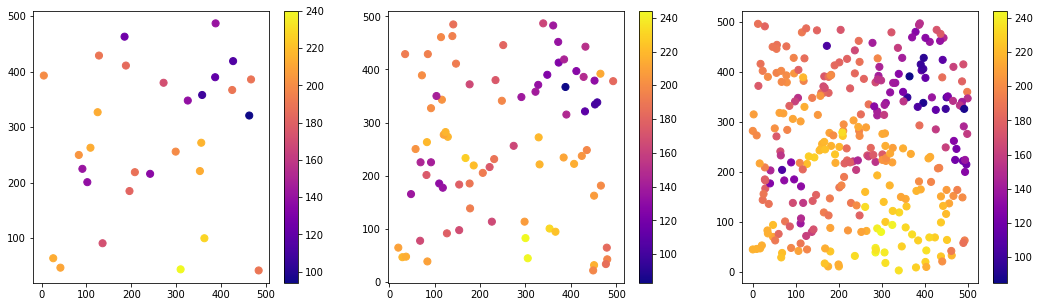

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for data, ax in zip((data1, data2, data3), axes.flatten()):
    plot_scatter(data, ax)

## 2.2 Comparing theoretical models

One of the features of `scikit-gstat` is the fact that it is programmed object oriented. That means, we can just instantiate a `Variogram` object and start changing arguments unitl it models spatial dependency in our observations well.

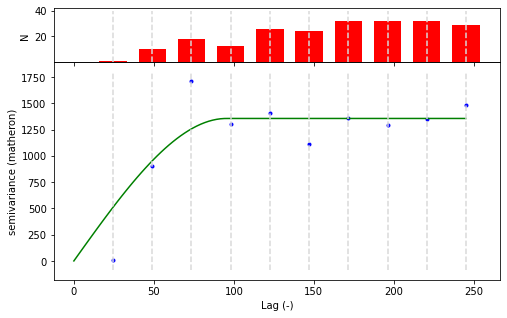

In [20]:
V1 = skg.Variogram(data1[['x', 'y']].values, data1.v.values, maxlag='median', normalize=False)
V1.plot(show=False);

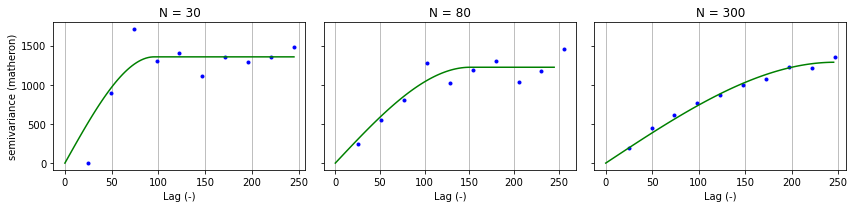

In [21]:
V2 = skg.Variogram(data2[['x', 'y']].values, data2.v.values, maxlag='median', normalize=False)
V3 = skg.Variogram(data3[['x', 'y']].values, data3.v.values, maxlag='median', normalize=False)

fig, _a = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
axes = _a.flatten()

x = np.linspace(0, V1.maxlag, 100)

# plot each variogram
for i, v in enumerate([V1, V2, V3]):
    axes[i].plot(v.bins, v.experimental, '.b')
    axes[i].plot(x, v.fitted_model(x), '-g')
    axes[i].set_title(f'N = {s[i]}')
    axes[i].set_xlabel('Lag (-)')
    if i == 0:
        axes[0].set_ylabel('semivariance (matheron)')
    axes[i].grid(which='major', axis='x')
plt.tight_layout()

We can see how the experimental variogram changes dramatically with sample size. Depending on the sample size, we can also choose different number of lag classes. As the Variogram is object oriented, we can simple update the binning function. First we set the number of lags directly, then we derive it from the distance matrix distribution. In the code below, we build the plot from scratch, demonstrating how you can access the empirical data and how it is updated, when new parameters are supplied.

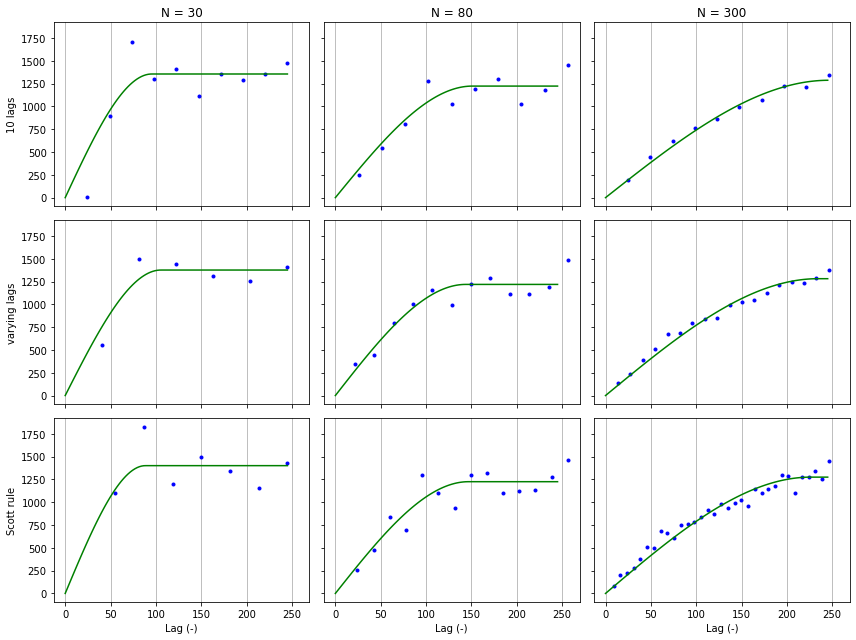

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(12, 9), sharey=True, sharex=True)

x = np.linspace(0, V1.maxlag, 100)
manual_lags = (6, 12, 18)
col_lab = ['10 lags', 'varying lags', 'Scott rule']

# plot each variogram
for i in range(3):
    for j, v in enumerate([V1, V2, V3]):
        # first row - use same settings
        if i == 0:
            v.bin_func = 'even'
            v.n_lags = 10
        # second row - use the manual lags
        if i == 1:
            v.n_lags = manual_lags[j]
        # last row - use scott
        if i == 2:
            v.bin_func = 'scott'
            axes[i][j].set_xlabel('Lag (-)')
        
        # plot
        axes[i][j].plot(v.bins, v.experimental, '.b')
        axes[i][j].plot(x, v.fitted_model(x), '-g')
        axes[i][j].grid(which='major', axis='x')
        
        # label first col
        if j == 0:
            axes[i][j].set_ylabel(col_lab[i])
        # title first row
        if i == 0:
            axes[i][j].set_title(f'N = {s[j]}')
plt.tight_layout()

That actually demonstrates how the selection of the experimental variogram can have huge influence on the base data for fitting. Now consider the center column. In each of the plots, the selection of model is not deterministic. You can argue for at least two different models here, that might actually be supported by the empirical data.
The `Variogram` class has several goodness of fit measures to help you on assessing the fit. This does not replace a careful visual inspection of the models, but can assist you in making an decision. Remember that the Kriging will be influenced by the quality of the spatial model, especially on short distances.
We can quickly cycle all available models for the sample size of 80 to see if spherical fits best. The histogram plot can be turned off.

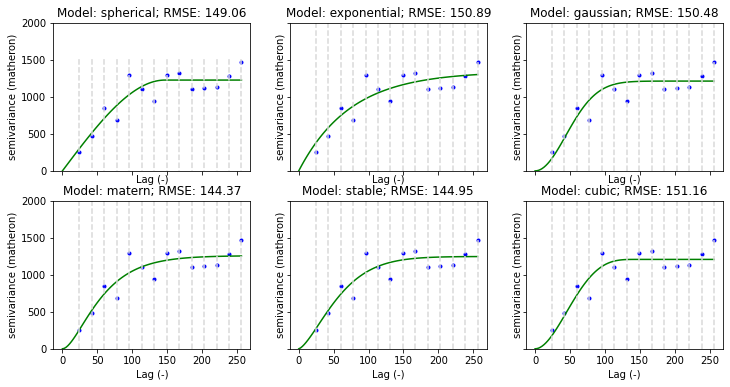

In [34]:
# we use the settings from before - scott rule
V2.bin_func = 'scott'
fig, _a = plt.subplots(2,3, figsize=(12, 6), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V2.model = model
    V2.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.2f' % (model, V2.rmse))
    axes[i].set_ylim(0, 2000)

This is quite important. We find all 6 models to describe the experimental variogram more or less equally well in terms of RMSE. Think of the implications: We basically can use any model we like. 
This is a problem as i.e. the gaussian and the spherical model describe fundamentally different spatial properties. Thus, our model selection should be driven by interpretation of the variogram, and not the difference in RMSE of only 0.4%, which might very likely not be significant at all.


But what does this difference look like, when it comes to interpolation?

In [43]:
def interpolate(V, ax):
    xx, yy = np.mgrid[0:499:100j, 0:499:100j]
    ok = skg.OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    art = ax.matshow(field, origin='lower', cmap='plasma', vmin=V.values.min(), vmax=V.values.max())
    ax.set_title('%s model' % V.model.__name__)
    plt.colorbar(art, ax=ax)
    return field

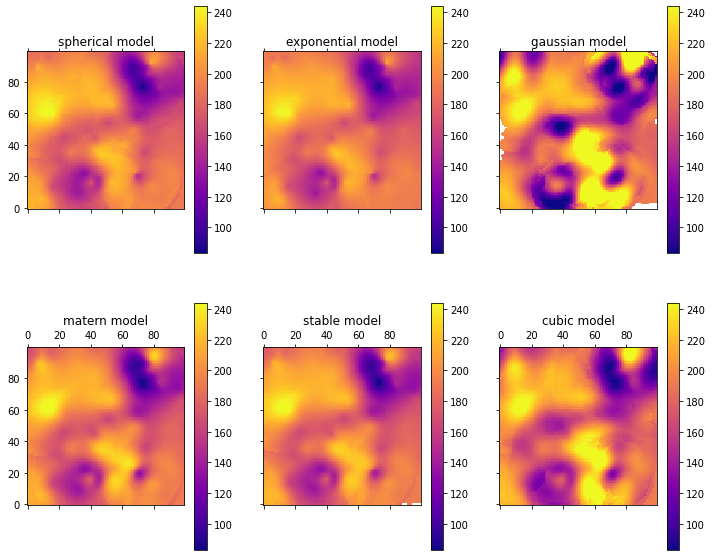

In [44]:
fields = []
fig, _a = plt.subplots(2,3, figsize=(12, 10), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V2.model = model
    fields.append(interpolate(V2, axes[i]))

In [45]:
pd.DataFrame({'spherical': fields[0].flatten(), 'exponential': fields[1].flatten(), 'gaussian': fields[2].flatten(),
              'matern': fields[3].flatten(), 'stable': fields[4].flatten(), 'cubic': fields[5].flatten()}).describe()

,spherical,exponential,gaussian,matern,stable,cubic
count,10000.000000,10000.000000,9890.000000,10000.000000,9991.000000,10000.000000
mean,184.534353,184.088046,186.461872,184.448945,184.338187,184.113831
std,28.085141,26.591814,48.119147,29.461639,28.974844,35.914252
min,84.118439,84.326126,60.090550,82.964854,83.216674,82.848879
25%,169.168862,169.127068,158.318778,168.355529,168.418711,160.532301
50%,187.594699,188.633479,188.561999,187.495603,187.525039,185.865217
75%,205.382495,202.859567,216.272628,206.765851,206.335498,212.219655
max,244.731745,243.522517,398.260676,249.272931,247.948390,263.676958


This should illustrate, how important the selection of model is, even if no observation uncertainties are propagated into the analysis.

1. Gaussian model is far off, producing estimations far outside the observed value ranges
2. All other models seem produce quite comparable mean values
3. BUT: the standard deviation is quite different
4. The median of the field can vary by more than 3 units, even if we took the Gaussian model out

You have to remind that we had quite some observations. The selection of model becomes even more arbitrary with smaller samples and more importantly: We have to consider more than one equally probable parameterization of each model when the experimental is more spreaded.

Finally, we can calculate the difference between the kriging fields to inspect the spread of estimations spatially:

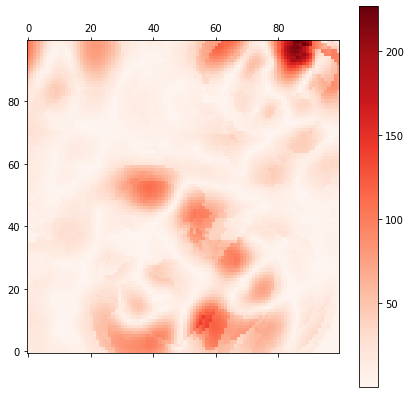

In [52]:
field_min = np.nanmin(np.stack(fields, axis=2), axis=2)
field_max = np.nanmax(np.stack(fields, axis=2), axis=2)

fig, ax = plt.subplots(1, 1, figsize=(7,7))
m = ax.matshow(field_max - field_min, origin='lower', cmap='Reds')
plt.colorbar(m)

The colorbar is spanning the entire value range. Thus, given the minor differences in the fitting of the models, we would have to reject just any estimation based on an automatic fit, which is considering some uncertainties in the selection of parameters, because the RMSE values were too close.

To use the result from above, we need to justfy the selection of model first and manually fit the model based on expert knowledge.

## 2.3 Using other sample sizes

Let's have a look at the sparse sample again

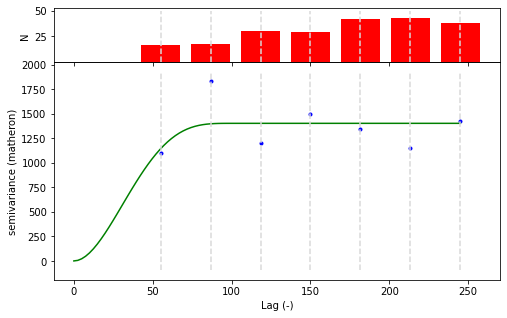

In [58]:
V1.plot(show=False);

This is a nugget-effect variogram. Thus we have to reject any geostatistical analysis based on this sample. It just does not expose any spatial pattern that can be exploited.

What about the denser sample. Increasing the sample size should reject some of the models. Remind, that we are sampling at more short distances and thus, the variogram will be governed by the short ranged patterns of the field, while the other samples are more dependent on the medium and large range patterns, as there were less short separating distances sampled.

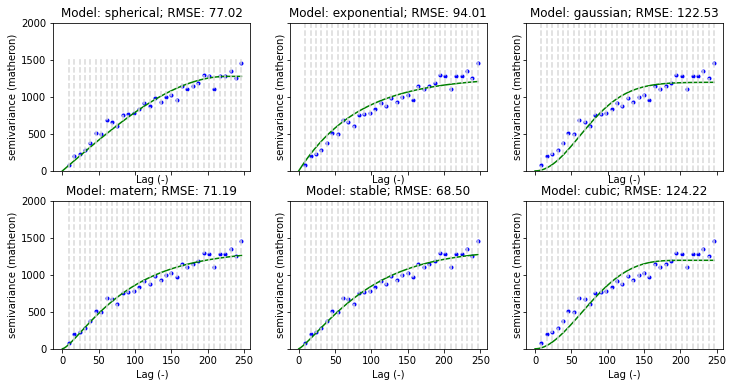

In [55]:
# we use the settings from before - scott rule
V3.bin_func = 'scott'
fig, _a = plt.subplots(2,3, figsize=(12, 6), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V3.model = model
    V3.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.2f' % (model, V3.rmse))
    axes[i].set_ylim(0, 2000)

We can now clearly reject the cubic, gaussian and exponential model. 
I personally would also reject the spherical model we used in the fist place, as it is systematically underestimating the semi-variance on short distances. 

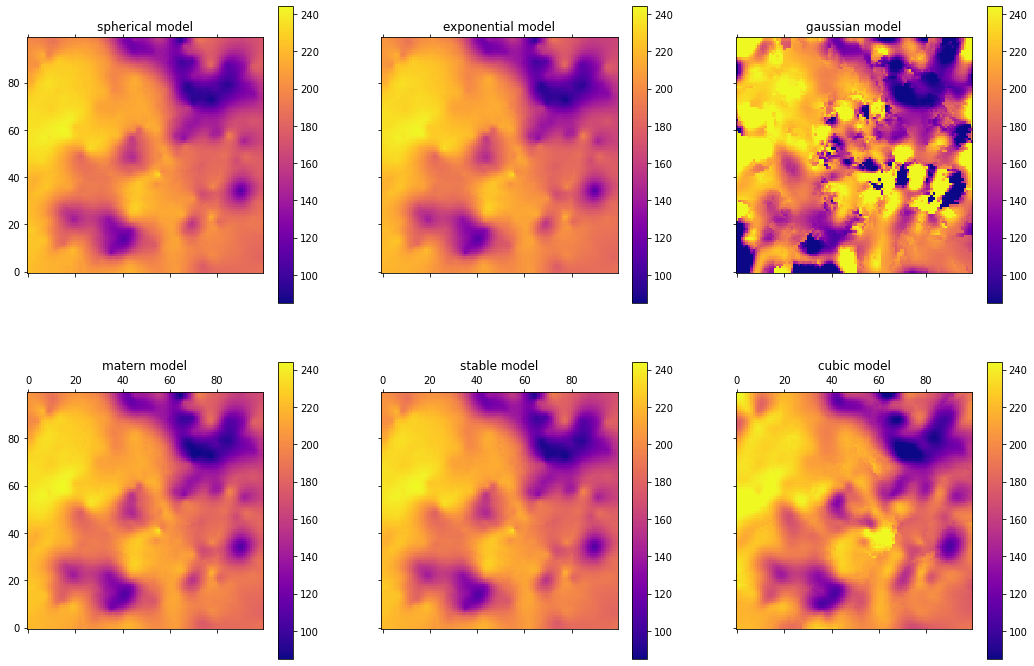

In [59]:
d_fields = []
fig, _a = plt.subplots(2,3, figsize=(18, 12), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V3.model = model
    d_fields.append(interpolate(V3, axes[i]))

In [60]:
pd.DataFrame({'spherical': d_fields[0].flatten(), 'exponential': d_fields[1].flatten(), 'gaussian': d_fields[2].flatten(),
              'matern': d_fields[3].flatten(), 'stable': d_fields[4].flatten(), 'cubic': d_fields[5].flatten()}).describe()

,spherical,exponential,gaussian,matern,stable,cubic
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,186.746369,186.501460,188.017572,186.839651,186.795057,188.097637
std,32.576157,32.353686,100.519330,33.397961,33.084211,35.940467
min,88.030671,88.342581,-1201.529475,83.294177,86.154432,56.361098
25%,167.688495,166.802809,156.078978,167.855878,167.771257,168.910398
50%,191.218375,191.155730,193.865877,191.499715,191.328717,193.001095
75%,211.672155,211.317278,222.579927,212.025633,211.922855,215.165573
max,243.613737,243.598604,1178.639919,244.335034,243.948692,265.643546


Finally, if we only concentrate on the not-rejected models: matern and stable, we can see hardly any difference in the field. Additionally, except for extrema, the statistical properties of the two fields are largely the same.